# IMPORT STATMENTS FOR ALL MODLES

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 seaborn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

2.1.0
2.2.4


Using TensorFlow backend.


In [3]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SeW_Merged_filtered.csv_train_testQTL_SNPS.csv", "SeW_Merged_filtered.csv_holdoutQTL_SNPS.csv")

10000
20000
(550,)
(550, 1)
30000
10000
20000
(138,)
(138, 1)
30000
(550, 21119)
(138, 21119)


In [5]:
##Only run if it hasn't been already generated

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)

In [6]:
pickle.dump(ohe, open("SeW_QTL_ohe.dat", "wb"))

In [7]:
#if need or have new holdout data etc.
ohe = pickle.load(open("SeW_QTL_ohe.dat", "rb"))

In [8]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 21119)
(550, 62175)
(138, 21119)
(138, 62175)


In [9]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [10]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 108005)
print(my_snp)

Not found


# XGBoost ML Model

In [11]:
print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

(550, 62175)
(550, 1)
(110, 62175)
seed is 4884


In [12]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}


In [13]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [14]:
xgbreg = xgb.XGBRegressor()
xgb_bayes_search = BayesSearchCV(xgbreg, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.598, total=  15.5s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.456, total=  11.6s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.1s remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.414, total=  12.1s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.0593607063591

[CV]  colsample_bylevel=0.25617325301227906, colsample_bytree=0.7083937150495909, gamma=2.41812432168581e-07, learning_rate=0.13965555720269418, max_delta_step=10, max_depth=27, min_child_weight=1, n_estimators=76, reg_alpha=3.178148842971562e-08, reg_lambda=0.005381781269387993, scale_pos_weight=0.23835043249575294, subsample=0.9559763235078597, score=0.585, total=   7.4s
[CV] colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909265e-09, scale_pos_weight=6.97020795804701e-06, subsample=0.46717487628832827 
[CV]  colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909

[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985, score=-20.536, total=   2.9s
[CV] colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985 
[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, 

[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868, score=0.193, total=  11.1s
[CV] colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868 
[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.74397517665941

[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086, score=-0.858, total=   8.4s
[CV] colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086 
[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, s

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.6min finished


best score: 0.5504615289832291
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01, score=-1.480, total=   8.1s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01, score=-2.540, total=   6.7s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s


[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01, score=-3.515, total=   7.5s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01 
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01, score=-2.514, total=   7.8s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=1e-06, subsample=0.01 
[CV]  colsample_bylevel=1.0, colsample_byt

[CV]  colsample_bylevel=0.5099691158709541, colsample_bytree=1.0, gamma=4.6699066068594404e-05, learning_rate=0.10197644867478678, max_delta_step=0, max_depth=50, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=0.00045546446126097813, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.565, total=  23.2s
[CV] colsample_bylevel=0.5099691158709541, colsample_bytree=1.0, gamma=4.6699066068594404e-05, learning_rate=0.10197644867478678, max_delta_step=0, max_depth=50, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=0.00045546446126097813, scale_pos_weight=499.99999999999994, subsample=1.0 
[CV]  colsample_bylevel=0.5099691158709541, colsample_bytree=1.0, gamma=4.6699066068594404e-05, learning_rate=0.10197644867478678, max_delta_step=0, max_depth=50, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=0.00045546446126097813, scale_pos_weight=499.99999999999994, subsample=1.0, score=0.333, total=  24.7s
[CV] colsample_bylevel=0.5099691158709

[CV]  colsample_bylevel=0.9831576775636349, colsample_bytree=0.01, gamma=0.04198563791420485, learning_rate=0.11044729774218066, max_delta_step=2, max_depth=2, min_child_weight=5, n_estimators=200, reg_alpha=0.9993316194285246, reg_lambda=1.0474262531265413e-08, scale_pos_weight=10.263770227077423, subsample=0.3710138669763133, score=0.579, total=   8.9s
[CV] colsample_bylevel=0.9831576775636349, colsample_bytree=0.01, gamma=0.04198563791420485, learning_rate=0.11044729774218066, max_delta_step=2, max_depth=2, min_child_weight=5, n_estimators=200, reg_alpha=0.9993316194285246, reg_lambda=1.0474262531265413e-08, scale_pos_weight=10.263770227077423, subsample=0.3710138669763133 
[CV]  colsample_bylevel=0.9831576775636349, colsample_bytree=0.01, gamma=0.04198563791420485, learning_rate=0.11044729774218066, max_delta_step=2, max_depth=2, min_child_weight=5, n_estimators=200, reg_alpha=0.9993316194285246, reg_lambda=1.0474262531265413e-08, scale_pos_weight=10.263770227077423, subsample=0.37

[CV]  colsample_bylevel=0.7649356168138838, colsample_bytree=0.688688659267344, gamma=1.7002699624246794e-09, learning_rate=0.4938031531431547, max_delta_step=3, max_depth=0, min_child_weight=0, n_estimators=89, reg_alpha=1.0, reg_lambda=1.8181225694002814, scale_pos_weight=1e-06, subsample=1.0, score=-0.011, total=   3.5s
[CV] colsample_bylevel=0.7649356168138838, colsample_bytree=0.688688659267344, gamma=1.7002699624246794e-09, learning_rate=0.4938031531431547, max_delta_step=3, max_depth=0, min_child_weight=0, n_estimators=89, reg_alpha=1.0, reg_lambda=1.8181225694002814, scale_pos_weight=1e-06, subsample=1.0 
[CV]  colsample_bylevel=0.7649356168138838, colsample_bytree=0.688688659267344, gamma=1.7002699624246794e-09, learning_rate=0.4938031531431547, max_delta_step=3, max_depth=0, min_child_weight=0, n_estimators=89, reg_alpha=1.0, reg_lambda=1.8181225694002814, scale_pos_weight=1e-06, subsample=1.0, score=-0.000, total=   3.6s
[CV] colsample_bylevel=0.6173912294632435, colsample_b

[CV]  colsample_bylevel=0.6776750675534478, colsample_bytree=0.01, gamma=5.7988181801302895e-05, learning_rate=0.10725552446769666, max_delta_step=0, max_depth=25, min_child_weight=5, n_estimators=193, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=0.0005905966005585543, subsample=1.0, score=0.500, total=   6.5s
[CV] colsample_bylevel=0.6776750675534478, colsample_bytree=0.01, gamma=5.7988181801302895e-05, learning_rate=0.10725552446769666, max_delta_step=0, max_depth=25, min_child_weight=5, n_estimators=193, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=0.0005905966005585543, subsample=1.0 
[CV]  colsample_bylevel=0.6776750675534478, colsample_bytree=0.01, gamma=5.7988181801302895e-05, learning_rate=0.10725552446769666, max_delta_step=0, max_depth=25, min_child_weight=5, n_estimators=193, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=0.0005905966005585543, subsample=1.0, score=0.418, total=   7.6s
[CV] colsample_bylevel=0.6776750675534478, colsample_bytree=0.01, ga

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  9.7min finished


best score: 0.5710947164989042
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517184e-08, scale_pos_weight=0.6644772112429821, subsample=0.5287387051998043 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517184e-08, scale_pos_weight=0.6644772112429821, subsample=0.5287387051998043, score=0.626, total=  12.2s
[CV] colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517184e-08, scale_pos_weight=0.6644772112429821, subsample=0.5287387051998043 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV]  colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517184e-08, scale_pos_weight=0.6644772112429821, subsample=0.5287387051998043, score=0.592, total=  11.9s
[CV] colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517184e-08, scale_pos_weight=0.6644772112429821, subsample=0.5287387051998043 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.0s remaining:    0.0s


[CV]  colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517184e-08, scale_pos_weight=0.6644772112429821, subsample=0.5287387051998043, score=0.436, total=  12.1s
[CV] colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517184e-08, scale_pos_weight=0.6644772112429821, subsample=0.5287387051998043 
[CV]  colsample_bylevel=0.2959726864626533, colsample_bytree=0.599695939665367, gamma=3.826939419587181e-09, learning_rate=0.028666736579844632, max_delta_step=15, max_depth=24, min_child_weight=3, n_estimators=155, reg_alpha=0.014842057907494299, reg_lambda=1.9650028408517

[CV]  colsample_bylevel=0.5533516657502582, colsample_bytree=1.0, gamma=1.6446145870040986e-05, learning_rate=0.09441642760850429, max_delta_step=0, max_depth=49, min_child_weight=5, n_estimators=200, reg_alpha=1.0, reg_lambda=8.201696508590998e-06, scale_pos_weight=70.69788106197716, subsample=1.0, score=0.624, total=  26.5s
[CV] colsample_bylevel=0.8350471536747698, colsample_bytree=1.0, gamma=1.2493955921371663e-09, learning_rate=0.019961067430207494, max_delta_step=16, max_depth=20, min_child_weight=5, n_estimators=177, reg_alpha=0.08464403200669755, reg_lambda=2.3960157606565797e-06, scale_pos_weight=2.130581482810374e-05, subsample=0.6511788337295389 
[CV]  colsample_bylevel=0.8350471536747698, colsample_bytree=1.0, gamma=1.2493955921371663e-09, learning_rate=0.019961067430207494, max_delta_step=16, max_depth=20, min_child_weight=5, n_estimators=177, reg_alpha=0.08464403200669755, reg_lambda=2.3960157606565797e-06, scale_pos_weight=2.130581482810374e-05, subsample=0.6511788337295

[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=0.01, score=-7.190, total=   6.9s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=0.01 
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=0.01, score=-9.438, total=   8.3s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=0.49999999999999994, learning_rate=0.01, max_delta_step=0, max_depth=0, min_child_weight=5, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weig

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  9.2min finished


best score: 0.5710947164989042
OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 1.0), ('gamma', 1e-09), ('learning_rate', 0.017639635558953492), ('max_delta_step', 16), ('max_depth', 19), ('min_child_weight', 5), ('n_estimators', 200), ('reg_alpha', 0.0001867178264504078), ('reg_lambda', 2.843960474044978e-05), ('scale_pos_weight', 1e-06), ('subsample', 0.45645280202476496)])


In [15]:
xgb_bayes_search.best_params_

OrderedDict([('colsample_bylevel', 1.0),
             ('colsample_bytree', 1.0),
             ('gamma', 1e-09),
             ('learning_rate', 0.017639635558953492),
             ('max_delta_step', 16),
             ('max_depth', 19),
             ('min_child_weight', 5),
             ('n_estimators', 200),
             ('reg_alpha', 0.0001867178264504078),
             ('reg_lambda', 2.843960474044978e-05),
             ('scale_pos_weight', 1e-06),
             ('subsample', 0.45645280202476496)])

In [16]:
##START HERE

#xgbreg = xgb_bayes_search.best_estimator_ #xgb.XGBRegressor(#n_estimators=100, nthread=-1) 
xgbreg = xgb.XGBRegressor(**xgb_bayes_search.best_params_)

In [17]:
print(xgbreg)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=1.0,
             colsample_bynode=None, colsample_bytree=1.0, gamma=1e-09,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.017639635558953492, max_delta_step=16,
             max_depth=19, min_child_weight=5, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:squarederror',
             random_state=None, reg_alpha=0.0001867178264504078,
             reg_lambda=2.843960474044978e-05, scale_pos_weight=1e-06,
             subsample=0.45645280202476496, tree_method=None,
             validate_parameters=None, verbosity=None)


In [18]:
def eval_k_fold(m, x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = m
    i = 1
    for train,test in cv.split(x,y):
        #print(y[test])
        m.fit(x[train],y[train].ravel())
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [19]:
best_model = eval_k_fold(xgbreg, tt_vcf, tt_pheno, 10)

fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.10750738522318903
RMSE for dataset is:3.283492421073642& mean of this fold is 12.051818
this is 27.244789540947608% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.2819366564718133
RMSE for dataset is:3.207140234188472& mean of this fold is 11.848183
this is 27.06862580776459% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.4351953204362611
RMSE for dataset is:2.62282981173264& mean of this fold is 12.892727
this is 20.343483829632454% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.7063424625063695
RMSE for dataset is:2.664387255252766& mean of this fold is 13.949091
this is 19.100794907306554% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.10694636247850131
RMSE for dataset is:3.304073051162306& mean o

In [20]:
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.04
RMSE of Holdout: 3.18
Mean of Holdout: 13.39
this is 23.741251386026878% of the mean pheno data


0 12.5 13.91655
1 8.1 9.143947
2 8.6 12.421118
3 6.1 11.999969
4 15.0 15.648996
5 6.5 8.943667


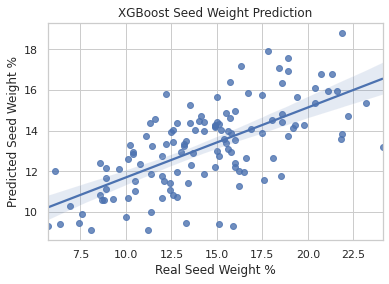

In [21]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Seed_Weight':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Seed_Weight", y="preds", data=thisplot)
plt.xlabel('Real Seed Weight %')
plt.ylabel('Predicted Seed Weight %')
plt.title("XGBoost Seed Weight Prediction")
plt.show()

In [22]:
pickle.dump(best_model, open("SeW_kfold_10_XGB_QTL.pickle.dat", "wb"))

In [23]:
#only load if not generated in same session
best_model = pickle.load(open("SeW_kfold_10_XGB_QTL.pickle.dat", "rb"))

<Figure size 1440x1440 with 0 Axes>

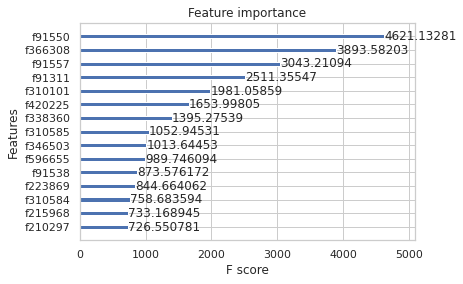

In [10]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("Oil_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [24]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("SeW_Merged_filtered.csv_train_testQTL_SNPS.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 29388
(550, 29388)
my header list is: 29388
my X value is: 58837
(550, 29449)
my header list is: 58837
dropping value so it doesn't include that in headers
my X value is: 62175
(550, 3338)
my header list is: 62175
62175


In [ ]:
## OLD GRAPH with MANUAL ENTRY 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [593927,29855,588433,594046,588431,154384,89664,238306,29856,133635,212368,97360,310115,214640,238315]
scores = [3788.51,3012.53,2338.82,1817.61,1267.10,956.13,721.52,464.87,423.59,387.93,344.70,308.57,249.15,241.69,225.54]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [25]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [26]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [27]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087


3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760


In [28]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})

Gm03_39147377 (G/G)    796.712964
Gm03_38195366 (A/A)     18.514034
Gm11_4404706 (A/A)     472.806641
Gm03_38500371 (C/C)     42.813214
Gm18_3226233 (A/A)      65.064941
                          ...    
Gm13_20028569 (G/A)      1.005728
Gm18_3518584 (C/C)       1.653558
Gm03_38467388 (A/A)      0.729543
Gm18_3340988 (A/A)       0.122457
Gm18_3330687 (A/A)       0.333352
Length: 3974, dtype: float64


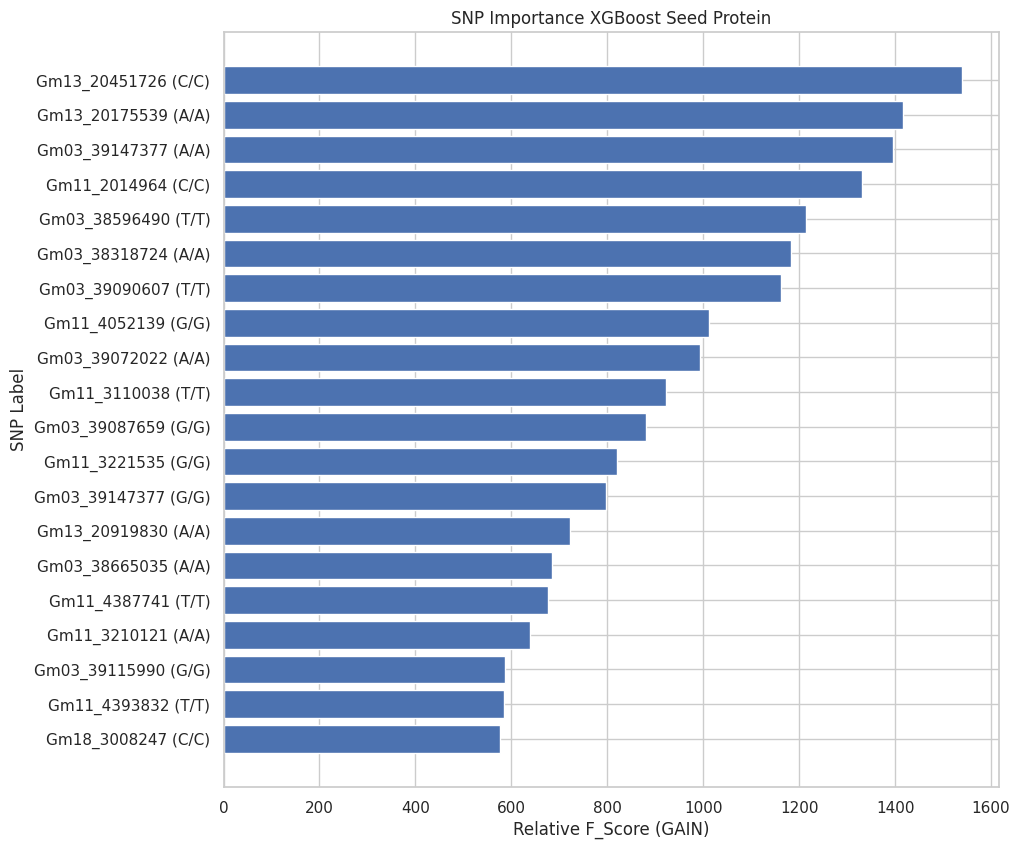

In [29]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Seed Protein')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

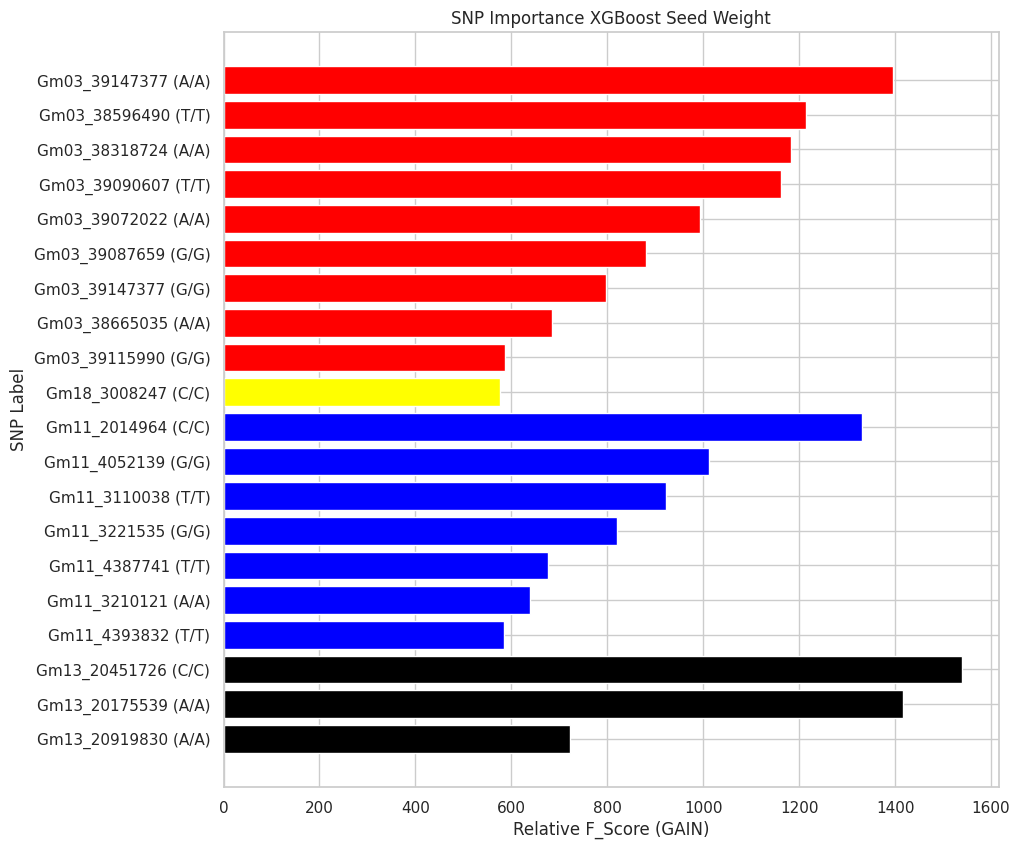

In [30]:
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
i = 0
while i < len(indexes):
    if('Gm03' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm11' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm12' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm18' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm08' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
plt.barh(bl_i, bl_v, color="black")
plt.barh(g_i, g_v, color="green")
plt.barh(p_i, p_v, color="orange")
plt.barh(b_i, b_v, color="blue")
plt.barh(y_i, y_v, color="yellow")
plt.barh(r_i, r_v, color="red")
plt.title('SNP Importance XGBoost Seed Weight')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# Random Forest Model

In [31]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SeW_Merged_filtered.csv_train_testQTL_SNPS.csv", "SeW_Merged_filtered.csv_holdoutQTL_SNPS.csv")

10000
20000
(550,)
(550, 1)
30000
10000
20000
(138,)
(138, 1)
30000
(550, 21119)
(138, 21119)


In [32]:
ohe = pickle.load(open("SeW_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 62175)
(138, 21119)
(138, 62175)


In [33]:
model = RandomForestRegressor(n_estimators=100, random_state=16, max_features = 'sqrt',n_jobs=-1, verbose = 1)
#trains the model, and makes the y shape as (m,) instead of (m,1)
#model.fit(X_train, y_train.ravel())

In [34]:
best_rf_model = eval_k_fold(model, tt_vcf, tt_pheno, 10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.21020858244219454
RMSE for dataset is:3.1181404685020033& mean of this fold is 12.367271
this is 25.2128409069875% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.8736707753783455
RMSE for dataset is:4.163391973345772& mean of this fold is 13.260907
this is 31.395981579401123% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.2076020022788171
RMSE for dataset is:2.6969983907227064& mean of this fold is 12.881817
this is 20.936475181982868% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.5009626300698908
RMSE for dataset is:3.431387159348542& mean of this fold is 13.675454
this is 25.09157739328604% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.08612741496559884
RMSE for dataset is:2.9915133478917726& mean of this fold is 13.1336355
this is 22.7774963232632% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.30356186630446336
RMSE for dataset is:3.1302581817023114& mean of this fold is 11.651817
this is 26.864978185435785% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.14282664708731985
RMSE for dataset is:3.5007930022074083& mean of this fold is 12.521817
this is 27.95754756870531% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.08950886054879925
RMSE for dataset is:3.3068749833412205& mean of this fold is 12.295455
this is 26.895100579885465% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.4806989544538982
RMSE for dataset is:2.4025936233820278& mean of this fold is 12.667272
this is 18.966938552991053% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.


fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.18406848311235147
RMSE for dataset is:2.760294516068925& mean of this fold is 13.430545
this is 20.552364377154078% of the mean pheno data
Training Testing Accuracy: 24.67% (3.65%)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


In [35]:
all_preds = [x for x in best_rf_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.


R^2 Value of Holdout: -0.01
RMSE of Holdout: 3.17
Mean of Holdout: 13.39
this is 23.63387477865552% of the mean pheno data


[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


In [36]:
pickle.dump(best_rf_model, open("SeW_kfold_10_RF_QTL.pickle.dat", "wb"))


In [37]:
#only load if not generated in same session
best_rf_model = pickle.load(open("SeW_kfold_10_RF_QTL.pickle.dat", "rb"))

range(0, 138)


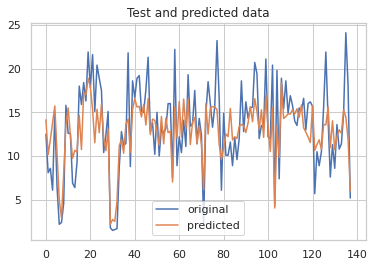

TypeError: list indices must be integers or slices, not range

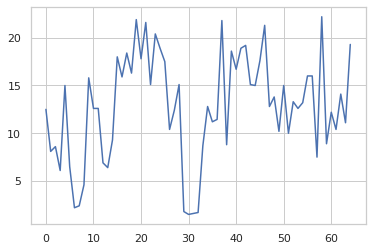

In [38]:
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="original")
plt.plot(x_ax, all_preds, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(ho_pheno)):
    i = i + interval
    if(i>len(ho_pheno)):
        my_range = range(i-interval,len(ho_pheno))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, ho_pheno[my_range], label="original")
    plt.plot(my_range, all_preds[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

# CNN Model (Based upon DL Primer & GMStools)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('SeW_Merged_filtered.csv_train_testQTL_SNPS.csv', 'SeW_Merged_filtered.csv_holdoutQTL_SNPS.csv')

10000
20000
(550,)
(550, 1)
30000
10000
20000
(138,)
(138, 1)
30000
(550, 21119)
(138, 21119)


In [5]:
ohe = pickle.load(open("SeW_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 62175)
(138, 21119)
(138, 62175)


In [6]:
def build_CNN_model(train_size):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=14, 
                     input_shape=(train_size, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(12, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(48, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"


    model.compile(loss='mean_squared_error', optimizer=opt, 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    print(model.summary())
    return model

In [7]:
def eval_CNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_CNN_model(x.shape[1])
        print("Fold:" + str(i))
        x = x.reshape(x.shape[0], x.shape[1], 1)
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [8]:
#my_model = build_CNN_model()
best_model = eval_CNN(tt_vcf, tt_pheno, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 62162, 12)         180       
_________________________________________________________________
activation (Activation)      (None, 62162, 12)         0         
_________________________________________________________________
dropout (Dropout)            (None, 62162, 12)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62153, 10)         1210      
_________________________________________________________________
activation_1 (Activation)    (None, 62153, 10)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62153, 10)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62146, 8)          6

Epoch 33/100
495/495 [==============================] - 1s 2ms/sample - loss: 5.0755 - root_mean_squared_error: 2.2529 - val_loss: 15.9451 - val_root_mean_squared_error: 3.9931
Epoch 34/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.3541 - root_mean_squared_error: 2.0867 - val_loss: 20.6432 - val_root_mean_squared_error: 4.5435
Epoch 35/100
495/495 [==============================] - 1s 1ms/sample - loss: 3.5820 - root_mean_squared_error: 1.8926 - val_loss: 13.2341 - val_root_mean_squared_error: 3.6379
Epoch 36/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.6351 - root_mean_squared_error: 1.9066 - val_loss: 16.7522 - val_root_mean_squared_error: 4.0929
Epoch 37/100
495/495 [==============================] - 1s 1ms/sample - loss: 3.7136 - root_mean_squared_error: 1.9271 - val_loss: 18.2583 - val_root_mean_squared_error: 4.2730
Epoch 38/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.8780 - root_mean_squared_error: 1.9

Epoch 10/100
495/495 [==============================] - 1s 2ms/sample - loss: 5.7214 - root_mean_squared_error: 2.3920 - val_loss: 72.9713 - val_root_mean_squared_error: 8.5423
Epoch 11/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.9866 - root_mean_squared_error: 2.2331 - val_loss: 35.3867 - val_root_mean_squared_error: 5.9487
Epoch 12/100
495/495 [==============================] - 1s 2ms/sample - loss: 6.0389 - root_mean_squared_error: 2.4574 - val_loss: 35.5236 - val_root_mean_squared_error: 5.9602
Epoch 13/100
495/495 [==============================] - 1s 2ms/sample - loss: 5.5937 - root_mean_squared_error: 2.3651 - val_loss: 18.4017 - val_root_mean_squared_error: 4.2897
Epoch 14/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.9727 - root_mean_squared_error: 2.2299 - val_loss: 14.0442 - val_root_mean_squared_error: 3.7476
Epoch 15/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.8957 - root_mean_squared_error: 2.2

Train on 495 samples, validate on 55 samples
Epoch 1/100
495/495 [==============================] - 1s 3ms/sample - loss: 169.7610 - root_mean_squared_error: 13.0292 - val_loss: 313.3065 - val_root_mean_squared_error: 17.7005
Epoch 2/100
495/495 [==============================] - 1s 2ms/sample - loss: 141.4470 - root_mean_squared_error: 11.8931 - val_loss: 383.9376 - val_root_mean_squared_error: 19.5943
Epoch 3/100
495/495 [==============================] - 1s 1ms/sample - loss: 113.1179 - root_mean_squared_error: 10.6357 - val_loss: 394.7115 - val_root_mean_squared_error: 19.8673
Epoch 4/100
495/495 [==============================] - 1s 1ms/sample - loss: 82.7168 - root_mean_squared_error: 9.0949 - val_loss: 333.9521 - val_root_mean_squared_error: 18.2744
Epoch 5/100
495/495 [==============================] - 1s 2ms/sample - loss: 55.4052 - root_mean_squared_error: 7.4435 - val_loss: 251.3659 - val_root_mean_squared_error: 15.8545
Epoch 6/100
495/495 [==============================] -

Epoch 47/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.0767 - root_mean_squared_error: 1.7541 - val_loss: 58.0284 - val_root_mean_squared_error: 7.6176
Epoch 48/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.4682 - root_mean_squared_error: 1.8623 - val_loss: 36.8512 - val_root_mean_squared_error: 6.0705
Epoch 49/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.0619 - root_mean_squared_error: 1.7498 - val_loss: 29.8434 - val_root_mean_squared_error: 5.4629
Epoch 50/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.4268 - root_mean_squared_error: 1.8512 - val_loss: 16.6722 - val_root_mean_squared_error: 4.0832
Epoch 51/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.4344 - root_mean_squared_error: 1.8532 - val_loss: 12.4825 - val_root_mean_squared_error: 3.5331
Epoch 52/100
495/495 [==============================] - 1s 1ms/sample - loss: 3.9419 - root_mean_squared_error: 1.9

Epoch 24/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.0001 - root_mean_squared_error: 2.0000 - val_loss: 16.6852 - val_root_mean_squared_error: 4.0847
Epoch 25/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.4428 - root_mean_squared_error: 2.1078 - val_loss: 9.9816 - val_root_mean_squared_error: 3.1594
Epoch 26/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.1315 - root_mean_squared_error: 2.0326 - val_loss: 12.2114 - val_root_mean_squared_error: 3.4945
Epoch 27/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.7286 - root_mean_squared_error: 1.9309 - val_loss: 10.5758 - val_root_mean_squared_error: 3.2520
Epoch 28/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.7386 - root_mean_squared_error: 1.9335 - val_loss: 11.0375 - val_root_mean_squared_error: 3.3223
Epoch 29/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.0234 - root_mean_squared_error: 1.73

495/495 [==============================] - 1s 3ms/sample - loss: 169.6597 - root_mean_squared_error: 13.0253 - val_loss: 161.5306 - val_root_mean_squared_error: 12.7095
Epoch 2/100
495/495 [==============================] - 1s 1ms/sample - loss: 141.4101 - root_mean_squared_error: 11.8916 - val_loss: 173.3272 - val_root_mean_squared_error: 13.1654
Epoch 3/100
495/495 [==============================] - 1s 1ms/sample - loss: 113.0166 - root_mean_squared_error: 10.6309 - val_loss: 156.1173 - val_root_mean_squared_error: 12.4947
Epoch 4/100
495/495 [==============================] - 1s 2ms/sample - loss: 80.5741 - root_mean_squared_error: 8.9763 - val_loss: 119.9424 - val_root_mean_squared_error: 10.9518
Epoch 5/100
495/495 [==============================] - 1s 1ms/sample - loss: 52.0560 - root_mean_squared_error: 7.2150 - val_loss: 88.6706 - val_root_mean_squared_error: 9.4165
Epoch 6/100
495/495 [==============================] - 1s 2ms/sample - loss: 30.0649 - root_mean_squared_error: 5

495/495 [==============================] - 1s 2ms/sample - loss: 3.5443 - root_mean_squared_error: 1.8826 - val_loss: 9.4969 - val_root_mean_squared_error: 3.0817
Epoch 94/100
495/495 [==============================] - 1s 2ms/sample - loss: 2.8614 - root_mean_squared_error: 1.6916 - val_loss: 15.9054 - val_root_mean_squared_error: 3.9882
Epoch 95/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.0891 - root_mean_squared_error: 1.7576 - val_loss: 9.2126 - val_root_mean_squared_error: 3.0352
Epoch 96/100
495/495 [==============================] - 1s 2ms/sample - loss: 2.1698 - root_mean_squared_error: 1.4730 - val_loss: 9.1530 - val_root_mean_squared_error: 3.0254
Epoch 97/100
495/495 [==============================] - 1s 2ms/sample - loss: 2.6265 - root_mean_squared_error: 1.6206 - val_loss: 8.8700 - val_root_mean_squared_error: 2.9783
Epoch 98/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.7228 - root_mean_squared_error: 1.9295 - val_loss: 2

Epoch 24/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.3125 - root_mean_squared_error: 2.0767 - val_loss: 20.7128 - val_root_mean_squared_error: 4.5511
Epoch 25/100
495/495 [==============================] - 1s 1ms/sample - loss: 3.3795 - root_mean_squared_error: 1.8383 - val_loss: 22.0581 - val_root_mean_squared_error: 4.6966
Epoch 26/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.9772 - root_mean_squared_error: 1.9943 - val_loss: 39.2386 - val_root_mean_squared_error: 6.2641
Epoch 27/100
495/495 [==============================] - 1s 1ms/sample - loss: 3.6456 - root_mean_squared_error: 1.9094 - val_loss: 17.5972 - val_root_mean_squared_error: 4.1949
Epoch 28/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.8142 - root_mean_squared_error: 1.9530 - val_loss: 17.7592 - val_root_mean_squared_error: 4.2142
Epoch 29/100
495/495 [==============================] - 1s 2ms/sample - loss: 2.9075 - root_mean_squared_error: 1.7

495/495 [==============================] - 2s 3ms/sample - loss: 169.4790 - root_mean_squared_error: 13.0184 - val_loss: 268.5888 - val_root_mean_squared_error: 16.3887
Epoch 2/100
495/495 [==============================] - 1s 2ms/sample - loss: 146.2250 - root_mean_squared_error: 12.0924 - val_loss: 324.8968 - val_root_mean_squared_error: 18.0249
Epoch 3/100
495/495 [==============================] - 1s 2ms/sample - loss: 116.6462 - root_mean_squared_error: 10.8003 - val_loss: 344.3862 - val_root_mean_squared_error: 18.5576
Epoch 4/100
495/495 [==============================] - 1s 1ms/sample - loss: 85.5338 - root_mean_squared_error: 9.2484 - val_loss: 331.1385 - val_root_mean_squared_error: 18.1972
Epoch 5/100
495/495 [==============================] - 1s 2ms/sample - loss: 55.0889 - root_mean_squared_error: 7.4222 - val_loss: 234.4405 - val_root_mean_squared_error: 15.3115
Epoch 6/100
495/495 [==============================] - 1s 2ms/sample - loss: 32.5749 - root_mean_squared_error:

495/495 [==============================] - 1s 2ms/sample - loss: 2.8554 - root_mean_squared_error: 1.6898 - val_loss: 15.4969 - val_root_mean_squared_error: 3.9366
Epoch 94/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.2013 - root_mean_squared_error: 1.7892 - val_loss: 22.9517 - val_root_mean_squared_error: 4.7908
Epoch 95/100
495/495 [==============================] - 1s 1ms/sample - loss: 2.9005 - root_mean_squared_error: 1.7031 - val_loss: 14.7684 - val_root_mean_squared_error: 3.8430
Epoch 96/100
495/495 [==============================] - 1s 2ms/sample - loss: 2.5523 - root_mean_squared_error: 1.5976 - val_loss: 15.2670 - val_root_mean_squared_error: 3.9073
Epoch 97/100
495/495 [==============================] - 1s 1ms/sample - loss: 2.3307 - root_mean_squared_error: 1.5267 - val_loss: 14.8282 - val_root_mean_squared_error: 3.8507
Epoch 98/100
495/495 [==============================] - 1s 1ms/sample - loss: 2.2592 - root_mean_squared_error: 1.5031 - val_los

Epoch 24/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.8742 - root_mean_squared_error: 1.9683 - val_loss: 8.6501 - val_root_mean_squared_error: 2.9411
Epoch 25/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.5956 - root_mean_squared_error: 2.1437 - val_loss: 5.9168 - val_root_mean_squared_error: 2.4325
Epoch 26/100
495/495 [==============================] - 1s 2ms/sample - loss: 5.4084 - root_mean_squared_error: 2.3256 - val_loss: 5.1019 - val_root_mean_squared_error: 2.2587
Epoch 27/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.2870 - root_mean_squared_error: 2.0705 - val_loss: 6.4417 - val_root_mean_squared_error: 2.5381
Epoch 28/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.1897 - root_mean_squared_error: 2.0469 - val_loss: 5.3887 - val_root_mean_squared_error: 2.3214
Epoch 29/100
495/495 [==============================] - 1s 1ms/sample - loss: 4.1534 - root_mean_squared_error: 2.0380 -

495/495 [==============================] - 1s 3ms/sample - loss: 167.4612 - root_mean_squared_error: 12.9407 - val_loss: 263.6069 - val_root_mean_squared_error: 16.2360
Epoch 2/100
495/495 [==============================] - 1s 2ms/sample - loss: 139.6458 - root_mean_squared_error: 11.8172 - val_loss: 321.9284 - val_root_mean_squared_error: 17.9424
Epoch 3/100
495/495 [==============================] - 1s 2ms/sample - loss: 107.3561 - root_mean_squared_error: 10.3613 - val_loss: 338.8310 - val_root_mean_squared_error: 18.4074
Epoch 4/100
495/495 [==============================] - 1s 2ms/sample - loss: 74.8477 - root_mean_squared_error: 8.6515 - val_loss: 189.0213 - val_root_mean_squared_error: 13.7485
Epoch 5/100
495/495 [==============================] - 1s 1ms/sample - loss: 46.5733 - root_mean_squared_error: 6.8245 - val_loss: 171.2884 - val_root_mean_squared_error: 13.0877
Epoch 6/100
495/495 [==============================] - 1s 2ms/sample - loss: 26.9664 - root_mean_squared_error:

495/495 [==============================] - 1s 2ms/sample - loss: 2.3844 - root_mean_squared_error: 1.5442 - val_loss: 14.8777 - val_root_mean_squared_error: 3.8572
Epoch 94/100
495/495 [==============================] - 1s 1ms/sample - loss: 3.8465 - root_mean_squared_error: 1.9612 - val_loss: 11.7635 - val_root_mean_squared_error: 3.4298
Epoch 95/100
495/495 [==============================] - 1s 2ms/sample - loss: 2.5657 - root_mean_squared_error: 1.6018 - val_loss: 9.5894 - val_root_mean_squared_error: 3.0967
Epoch 96/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.4766 - root_mean_squared_error: 1.8646 - val_loss: 13.7347 - val_root_mean_squared_error: 3.7060
Epoch 97/100
495/495 [==============================] - 1s 2ms/sample - loss: 2.4675 - root_mean_squared_error: 1.5708 - val_loss: 9.8942 - val_root_mean_squared_error: 3.1455
Epoch 98/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.1594 - root_mean_squared_error: 1.7775 - val_loss:

Epoch 24/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.2572 - root_mean_squared_error: 1.8048 - val_loss: 11.5638 - val_root_mean_squared_error: 3.4006
Epoch 25/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.9756 - root_mean_squared_error: 1.9939 - val_loss: 11.7786 - val_root_mean_squared_error: 3.4320
Epoch 26/100
495/495 [==============================] - 1s 2ms/sample - loss: 4.5384 - root_mean_squared_error: 2.1304 - val_loss: 8.1246 - val_root_mean_squared_error: 2.8504
Epoch 27/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.6905 - root_mean_squared_error: 1.9211 - val_loss: 31.6122 - val_root_mean_squared_error: 5.6225
Epoch 28/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.1854 - root_mean_squared_error: 1.7848 - val_loss: 14.2264 - val_root_mean_squared_error: 3.7718
Epoch 29/100
495/495 [==============================] - 1s 2ms/sample - loss: 3.9416 - root_mean_squared_error: 1.98

In [ ]:
#pickle.dump(best_model, open("Oil_kfold_10_CNN.pickle.dat", "wb"))

In [ ]:
#best_CNN = pickle.load(open("Oil_kfold_10_CNN.pickle.dat", "rb"))

In [9]:
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.40
RMSE of Holdout: 3.22
Mean of Holdout: 13.39
this is 24.058445059520587% of the mean pheno data


False
False
0 12.5 [16.327688]
1 8.1 [11.08228]
2 8.6 [16.417484]
3 6.1 [8.878278]
4 15.0 [16.724073]
5 6.5 [10.093423]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

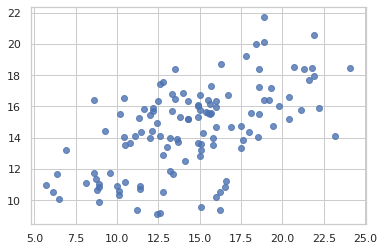

In [10]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()
print(np.isinf(ho_pheno).any())
print(np.isinf(all_preds).any())
for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'SeW':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="SeW", y="preds", data=thisplot)
plt.xlabel('Real Seed weight %')
plt.ylabel('Predicted Seed weight %')
plt.title("XGBoost Seed weight Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
all_preds = [x[0] for x in model.predict(X_test)]
sqrt(mean_squared_error(all_preds, y_test))
r2_score(all_preds, y_test)
vcf = vcf.reshape(vcf.shape[0], vcf.shape[1], 1)
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

# DNN model
#### Model Based upon: Crop Yield Prediction Using Deep Neural Networks(2019)

In [11]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('SeW_Merged_filtered.csv_train_testQTL_SNPS.csv', 'SeW_Merged_filtered.csv_holdoutQTL_SNPS.csv')

10000
20000
(550,)
(550, 1)
30000
10000
20000
(138,)
(138, 1)
30000
(550, 21119)
(138, 21119)


In [12]:
ohe = pickle.load(open("SeW_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 62175)
(138, 21119)
(138, 62175)


In [13]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(200, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    print(model.summary())
    return model




In [14]:
def eval_DNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_DNN_model(x.shape[1])
        print("Fold:" + str(i))
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=50, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [15]:
#my_model = build_CNN_model()
best_DNN = eval_DNN(tt_vcf, tt_pheno, 10)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 200)               12435200  
_________________________________________________________________
activation_30 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_31 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)              

495/495 [==============================] - 0s 638us/sample - loss: 10.9248 - root_mean_squared_error: 3.3053 - val_loss: 10.9049 - val_root_mean_squared_error: 3.3023
Epoch 15/50
495/495 [==============================] - 0s 634us/sample - loss: 8.7824 - root_mean_squared_error: 2.9635 - val_loss: 9.8450 - val_root_mean_squared_error: 3.1377
Epoch 16/50
495/495 [==============================] - 0s 638us/sample - loss: 8.3910 - root_mean_squared_error: 2.8967 - val_loss: 8.8481 - val_root_mean_squared_error: 2.9746
Epoch 17/50
495/495 [==============================] - 0s 637us/sample - loss: 8.2676 - root_mean_squared_error: 2.8753 - val_loss: 9.1074 - val_root_mean_squared_error: 3.0179
Epoch 18/50
495/495 [==============================] - 0s 633us/sample - loss: 9.5657 - root_mean_squared_error: 3.0928 - val_loss: 9.1383 - val_root_mean_squared_error: 3.0230
Epoch 19/50
495/495 [==============================] - 0s 636us/sample - loss: 7.5648 - root_mean_squared_error: 2.7504 - val

Total params: 12,464,517
Trainable params: 12,464,453
Non-trainable params: 64
_________________________________________________________________
None
Fold:3
Train on 495 samples, validate on 55 samples
Epoch 1/50
495/495 [==============================] - 1s 2ms/sample - loss: 157.3898 - root_mean_squared_error: 12.5455 - val_loss: 44.1978 - val_root_mean_squared_error: 6.6481
Epoch 2/50
495/495 [==============================] - 0s 632us/sample - loss: 83.2472 - root_mean_squared_error: 9.1240 - val_loss: 63.1572 - val_root_mean_squared_error: 7.9471
Epoch 3/50
495/495 [==============================] - 0s 633us/sample - loss: 34.8360 - root_mean_squared_error: 5.9022 - val_loss: 90.3857 - val_root_mean_squared_error: 9.5071
Epoch 4/50
495/495 [==============================] - 0s 634us/sample - loss: 27.0879 - root_mean_squared_error: 5.2046 - val_loss: 72.7954 - val_root_mean_squared_error: 8.5320
Epoch 5/50
495/495 [==============================] - 0s 633us/sample - loss: 19.9377 

Epoch 46/50
495/495 [==============================] - 0s 634us/sample - loss: 4.1288 - root_mean_squared_error: 2.0319 - val_loss: 10.0626 - val_root_mean_squared_error: 3.1722
Epoch 47/50
495/495 [==============================] - 0s 635us/sample - loss: 4.3780 - root_mean_squared_error: 2.0924 - val_loss: 10.1246 - val_root_mean_squared_error: 3.1819
Epoch 48/50
495/495 [==============================] - 0s 634us/sample - loss: 4.6354 - root_mean_squared_error: 2.1530 - val_loss: 10.6529 - val_root_mean_squared_error: 3.2639
Epoch 49/50
495/495 [==============================] - 0s 633us/sample - loss: 4.5477 - root_mean_squared_error: 2.1325 - val_loss: 10.0454 - val_root_mean_squared_error: 3.1694
Epoch 50/50
495/495 [==============================] - 0s 630us/sample - loss: 4.0148 - root_mean_squared_error: 2.0037 - val_loss: 9.2760 - val_root_mean_squared_error: 3.0457
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.2539666900031936
RMSE for dataset 

495/495 [==============================] - 0s 628us/sample - loss: 11.7997 - root_mean_squared_error: 3.4351 - val_loss: 13.0611 - val_root_mean_squared_error: 3.6140
Epoch 9/50
495/495 [==============================] - 0s 629us/sample - loss: 11.0167 - root_mean_squared_error: 3.3191 - val_loss: 13.1137 - val_root_mean_squared_error: 3.6213
Epoch 10/50
495/495 [==============================] - 0s 630us/sample - loss: 10.4538 - root_mean_squared_error: 3.2332 - val_loss: 12.4768 - val_root_mean_squared_error: 3.5323
Epoch 11/50
495/495 [==============================] - 0s 629us/sample - loss: 10.6049 - root_mean_squared_error: 3.2565 - val_loss: 12.9375 - val_root_mean_squared_error: 3.5969
Epoch 12/50
495/495 [==============================] - 0s 629us/sample - loss: 9.6839 - root_mean_squared_error: 3.1119 - val_loss: 12.4686 - val_root_mean_squared_error: 3.5311
Epoch 13/50
495/495 [==============================] - 0s 629us/sample - loss: 8.7650 - root_mean_squared_error: 2.9606

dense_73 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_58 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32)                128       
_________________________________________________________________
dense_74 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_59 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 17        
Total params: 12,464,517
Trainable params: 12,464,453
Non-trainable params: 64
_________________________________________________________________
None
Fold:6
Train on 495 samples, validate on 55 samples
Epoch 1/50
495/495 [==============================] - 1s 2ms/sample - lo

495/495 [==============================] - 0s 630us/sample - loss: 9.1413 - root_mean_squared_error: 3.0235 - val_loss: 5.2817 - val_root_mean_squared_error: 2.2982
Epoch 23/50
495/495 [==============================] - 0s 632us/sample - loss: 8.2145 - root_mean_squared_error: 2.8661 - val_loss: 5.0504 - val_root_mean_squared_error: 2.2473
Epoch 24/50
495/495 [==============================] - 0s 632us/sample - loss: 7.8042 - root_mean_squared_error: 2.7936 - val_loss: 4.5317 - val_root_mean_squared_error: 2.1288
Epoch 25/50
495/495 [==============================] - 0s 632us/sample - loss: 6.8851 - root_mean_squared_error: 2.6239 - val_loss: 5.5539 - val_root_mean_squared_error: 2.3567
Epoch 26/50
495/495 [==============================] - 0s 633us/sample - loss: 6.7115 - root_mean_squared_error: 2.5907 - val_loss: 5.0934 - val_root_mean_squared_error: 2.2569
Epoch 27/50
495/495 [==============================] - 0s 631us/sample - loss: 7.1938 - root_mean_squared_error: 2.6821 - val_l

495/495 [==============================] - 0s 630us/sample - loss: 4.8679 - root_mean_squared_error: 2.2063 - val_loss: 8.1855 - val_root_mean_squared_error: 2.8610
Epoch 50/50
495/495 [==============================] - 0s 629us/sample - loss: 5.1450 - root_mean_squared_error: 2.2682 - val_loss: 8.8040 - val_root_mean_squared_error: 2.9671
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.4773540253324181
RMSE for dataset is:2.9671457875289318& mean of this fold is 12.0081835
this is 24.709364181864192% of the mean pheno data
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               12435200  
_________________________________________________________________
activation_70 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_44 (Dropout)  

495/495 [==============================] - 0s 634us/sample - loss: 10.5299 - root_mean_squared_error: 3.2450 - val_loss: 15.6375 - val_root_mean_squared_error: 3.9544
Epoch 12/50
495/495 [==============================] - 0s 632us/sample - loss: 10.7228 - root_mean_squared_error: 3.2746 - val_loss: 11.9345 - val_root_mean_squared_error: 3.4546
Epoch 13/50
495/495 [==============================] - 0s 630us/sample - loss: 9.2354 - root_mean_squared_error: 3.0390 - val_loss: 13.5142 - val_root_mean_squared_error: 3.6762
Epoch 14/50
495/495 [==============================] - 0s 635us/sample - loss: 9.1948 - root_mean_squared_error: 3.0323 - val_loss: 8.5772 - val_root_mean_squared_error: 2.9287
Epoch 15/50
495/495 [==============================] - 0s 634us/sample - loss: 10.3119 - root_mean_squared_error: 3.2112 - val_loss: 13.4865 - val_root_mean_squared_error: 3.6724
Epoch 16/50
495/495 [==============================] - 0s 634us/sample - loss: 9.7452 - root_mean_squared_error: 3.1217 

In [16]:
#ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_DNN.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: -0.18
RMSE of Holdout: 3.66
Mean of Holdout: 13.39
this is 27.308561042908458% of the mean pheno data


0 17.6 [16.134573]
1 23.6 [19.051014]
2 15.1 [15.280489]
3 19.2 [18.973824]
4 14.5 [16.545984]
5 14.9 [14.623625]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

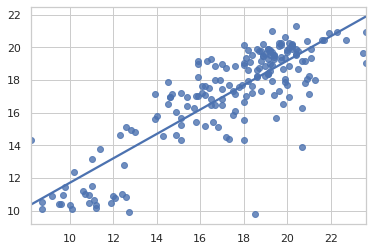

In [11]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("DNN Seed Oil Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()

In [ ]:
pickle.dump(best_DNN, open("Oil_kfold_10_DNN.pickle.dat", "wb"))

In [ ]:
best_DNN = pickle.load(open("Oil_kfold_10_DNN.pickle.dat", "rb"))

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

range(0, 189)


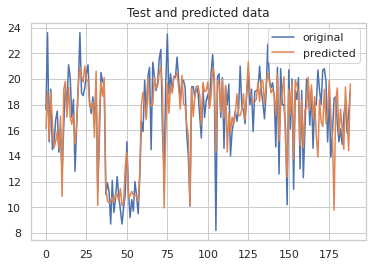

TypeError: list indices must be integers or slices, not range

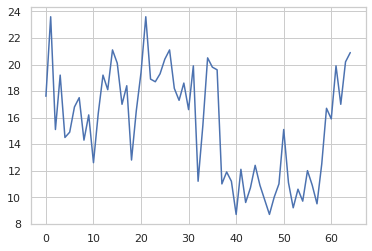

In [10]:
y_test=ho_pheno
x_ax = range(len(y_test))
print(x_ax)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, all_preds, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(y_test)):
    i = i + interval
    if(i>len(y_test)):
        my_range = range(i-interval,len(y_test))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, y_test[my_range], label="original")
    plt.plot(my_range, all_preds[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

In [ ]:
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

In [ ]:
ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")